### Data Collection and Analysis

In [2]:
#All libraries required
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

Using TensorFlow backend.


In [2]:
#read captions
def readTextFile(path):
    with open(path) as f:
        captions=f.read()
    return captions

In [3]:
captions=readTextFile(r'E:\Flickr_Data\Flickr_TextData\Flickr8k.token.txt')#replace location as per your storage
captions=captions.split("\n")[:-1] ##last line is empty
print(len(captions))
captions[0].split('\t')

40460


['1000268201_693b08cb0e.jpg#0',
 'A child in a pink dress is climbing up a set of stairs in an entry way .']

In [4]:
# Dictionary to map each image with list of captions it has.
#key=img_id value=[list of captions it has]
descriptions = {}

for x in captions:
    first,second = x.split('\t')
    img_name = first.split('.')[0] # img_id
    
    #if the img_id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
    
    descriptions[img_name].append(second)
    

In [5]:
IMG_PATH=r'E:\Flickr_Data\Flickr_Data\Images'#replace location as per your storage

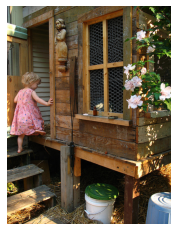

In [6]:
#checking mapping
import cv2
import matplotlib.pyplot as plt

img=cv2.imread(IMG_PATH+"/1000268201_693b08cb0e.jpg")
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

### Data Cleaning

In [7]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence = [s for s in sentence if len(s)>1] #just to reduce vocab
    sentence = " ".join(sentence)
    return sentence

In [8]:
# cleaning all captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i]=clean_text(caption_list[i])

In [9]:
# writing data to text file
with open("descriptions.txt","w") as f:
    f.write(str(descriptions))
    f.close()

In [10]:
#creating a vocab
descriptions = None
with open("descriptions.txt") as f:
    descriptions = f.read() #currently it is a st
    
json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [11]:
vocab = set() #stores all unique words
#iterate over all unique words
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]

print("Vocab Size : %d"% len(vocab))

Vocab Size : 8424


In [12]:
# Total No of words across all the sentence
total_words = []

for key in descriptions.keys():
    #des is list of captions-remember that we have more than one caption of a single image in our dataset
    #i is every word in that list
    [total_words.append(i) for des in descriptions[key] for i in des.split()]

print("Total Words %d"% len(total_words))

Total Words 373837


In [13]:
#Filter words fro vocab according certain threshold frequency
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)


In [14]:
# sort this dictinory according to frequency count
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1]) #remember sorted function works on list

# Filter
threshold = 10
sorted_freq_cnt = [x for x in sorted_freq_cnt  if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [15]:
print(len(total_words))

1845


### Prepare Train/Test Data

In [16]:
train_file_data = readTextFile(r'E:\Flickr_Data\Flickr_TextData\Flickr_8k.trainImages.txt')
test_file_data = readTextFile(r'E:\Flickr_Data\Flickr_TextData\Flickr_8k.testImages.txt')

In [17]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [18]:
#Preparing description for training data
#Tweak- Add <s> and <e> token to our training data
train_description = {}

for img_id in train:
    train_description[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq " + cap + " endseq"
        train_description[img_id].append(cap_to_append)

In [19]:
train_description["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

### Transfer Learning
- Images-->Features
- Text-->Features


#### Step-1 Image Feature Extraction

In [20]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [21]:
model_new = Model(model.input,model.layers[-2].output)

In [22]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)#convert 3d to 4d tensor(1,224,224,3) resnet need image in batches
    #Normalize
    img = preprocess_input(img)
    return img
    

In [25]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img) #current shape is (1,2048)
    feature_vector = feature_vector.reshape((-1,))#converting output to single axis
    return feature_vector

In [26]:
start = time()
encoding_train = {}
#img_id -->feature_vector extracted from resnet image

for ix,img_id in enumerate(train):
    image_path = IMG_PATH+'\\'+img_id+".jpg"
    encoding_train[img_id] = encode_image(image_path)
    
    if ix%100==0:
        print("Encoding in progress Time step %d"%ix)

end_t = time()
print("Total Time Taken :",end_t-start)

Encoding in progress Time step 0
Encoding in progress Time step 100
Encoding in progress Time step 200
Encoding in progress Time step 300
Encoding in progress Time step 400
Encoding in progress Time step 500
Encoding in progress Time step 600
Encoding in progress Time step 700
Encoding in progress Time step 800
Encoding in progress Time step 900
Encoding in progress Time step 1000
Encoding in progress Time step 1100
Encoding in progress Time step 1200
Encoding in progress Time step 1300
Encoding in progress Time step 1400
Encoding in progress Time step 1500
Encoding in progress Time step 1600
Encoding in progress Time step 1700
Encoding in progress Time step 1800
Encoding in progress Time step 1900
Encoding in progress Time step 2000
Encoding in progress Time step 2100
Encoding in progress Time step 2200
Encoding in progress Time step 2300
Encoding in progress Time step 2400
Encoding in progress Time step 2500
Encoding in progress Time step 2600
Encoding in progress Time step 2700
Enco

In [41]:
# store everything to the disk //
with open("encoding_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [28]:
#repeat
start = time()
encoding_test = {}
#img_id -->feature_vector extracted from resnet image

for ix,img_id in enumerate(test):
    image_path = IMG_PATH+'\\'+img_id+".jpg"
    encoding_test[img_id] = encode_image(image_path)
    
    if ix%100==0:
        print("Encoding in progress Time step %d"%ix)

end_t = time()
print("Total Time Taken :",end_t-start)

Encoding in progress Time step 0
Encoding in progress Time step 100
Encoding in progress Time step 200
Encoding in progress Time step 300
Encoding in progress Time step 400
Encoding in progress Time step 500
Encoding in progress Time step 600
Encoding in progress Time step 700
Encoding in progress Time step 800
Encoding in progress Time step 900
Total Time Taken : 43.490323543548584


In [40]:
with open("encoding_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

#### Step-2 Data Pre-processing for captions

In [30]:
#vocab
len(total_words)

1845

In [56]:
word_to_idx = {}
idx_to_word = {}
for i,word in enumerate(total_words):
    word_to_idx[word]=i+1
    idx_to_word[i+1]=word 

In [61]:
#Two special words 

idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx)+1
print("Vocab Size",vocab_size)

Vocab Size 1848


In [62]:
max_len = 0
for key in train_description.keys():
    for cap in train_description[key]:
        max_len=max(max_len,len(cap.split()))
print(max_len)

35


### Data Loader(Generator)

In [63]:
 def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0

### Word embeddings

In [64]:
f = open('glove.6B.50d.txt',encoding='utf8')

In [65]:
embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding

In [66]:
f.close()
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [67]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix
        

In [68]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

### Model Architecture

In [70]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [71]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [72]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 35, 50)       92400       input_5[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 2048)         0           input_4[0][0]                    
____________________________________________________________________________________________

In [73]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
model.compile(loss='categorical_crossentropy',optimizer="adam")

### Training of Model

In [74]:
epochs = 20
batch_size = 3
steps = len(train_description)//batch_size


In [77]:
def train(epochs):
    
    for i in range(epochs):
        generator = data_generator(train_description,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./model_'+str(i)+'.h5')

In [78]:
# Trained it on GTX 1050Ti ,You can use google colab as well
train(epochs)

Epoch 1/1
2000/2000 [==============================] - 140s 70ms/step - loss: 3.5764
Epoch 1/1
2000/2000 [==============================] - 138s 69ms/step - loss: 3.3189
Epoch 1/1
2000/2000 [==============================] - 139s 69ms/step - loss: 3.1601
Epoch 1/1
2000/2000 [==============================] - 145s 72ms/step - loss: 3.0507
Epoch 1/1
2000/2000 [==============================] - 144s 72ms/step - loss: 2.9624
Epoch 1/1
2000/2000 [==============================] - 145s 73ms/step - loss: 2.8944
Epoch 1/1
2000/2000 [==============================] - 144s 72ms/step - loss: 2.8380
Epoch 1/1
2000/2000 [==============================] - 144s 72ms/step - loss: 2.7941
Epoch 1/1
2000/2000 [==============================] - 145s 72ms/step - loss: 2.7535
Epoch 1/1
2000/2000 [==============================] - 145s 73ms/step - loss: 2.7175
Epoch 1/1
2000/2000 [==============================] - 142s 71ms/step - loss: 2.6872
Epoch 1/1
2000/2000 [==============================] - 142s 71ms/

In [3]:
model = load_model('./model_19.h5')

### Predictions

In [139]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

In [50]:
encoding_test

{'3385593926_d3e9c21170': array([0.28236094, 0.31681883, 0.04513436, ..., 0.74424064, 0.2965146 ,
        0.9206251 ], dtype=float32),
 '2677656448_6b7e7702af': array([0.23350677, 0.05166636, 0.62427086, ..., 0.00522081, 0.26217794,
        0.08686358], dtype=float32),
 '311146855_0b65fdb169': array([0.00912153, 0.07213545, 0.12207071, ..., 0.0220319 , 1.1318821 ,
        0.03855693], dtype=float32),
 '1258913059_07c613f7ff': array([0.02427822, 1.2347245 , 0.0759519 , ..., 0.0889706 , 0.09812833,
        1.9384187 ], dtype=float32),
 '241347760_d44c8d3a01': array([0.05051169, 6.3199906 , 0.3120085 , ..., 0.05379442, 0.01552999,
        0.02812636], dtype=float32),
 '2654514044_a70a6e2c21': array([1.7663001 , 0.03384984, 0.10334554, ..., 0.00532009, 0.66801536,
        0.39294156], dtype=float32),
 '2339106348_2df90aa6a9': array([0.0668316 , 1.0869437 , 0.07896084, ..., 0.01411183, 0.1311435 ,
        0.09507988], dtype=float32),
 '256085101_2c2617c5d0': array([0.5742959 , 0.51020294, 0

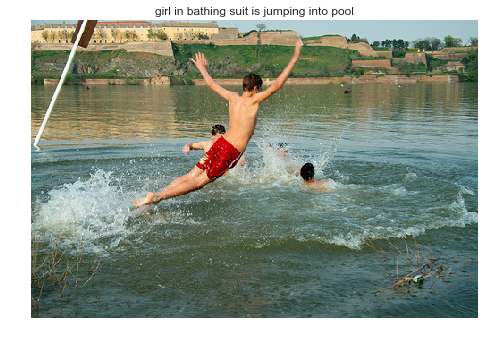

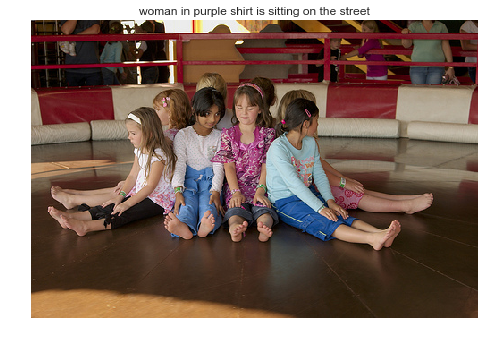

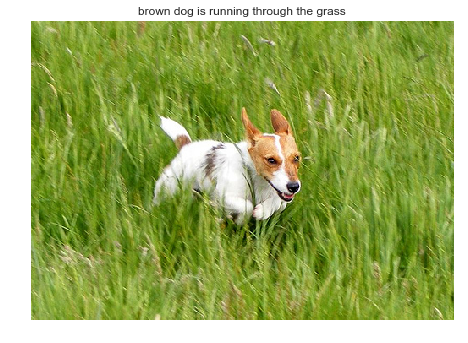

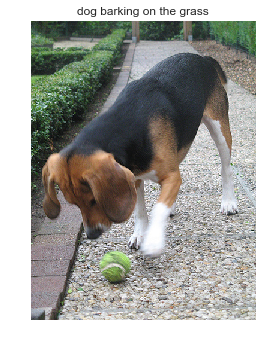

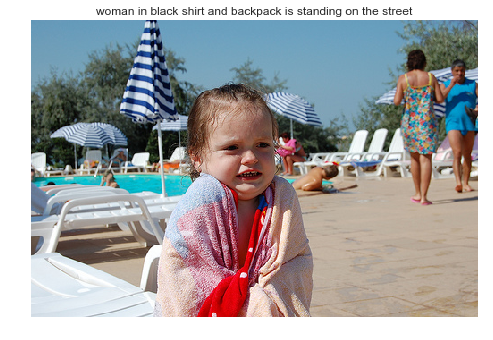

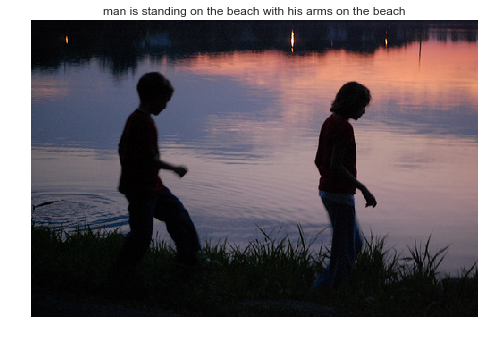

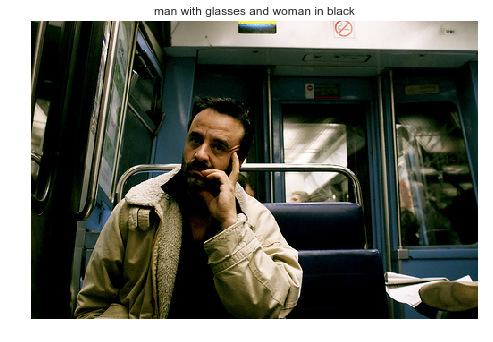

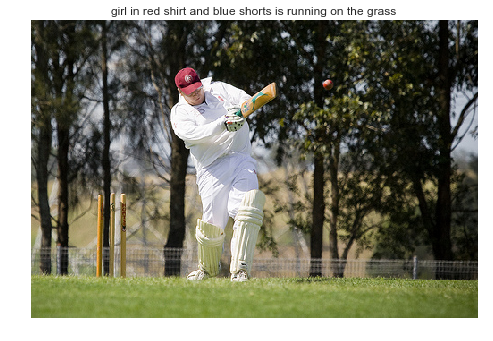

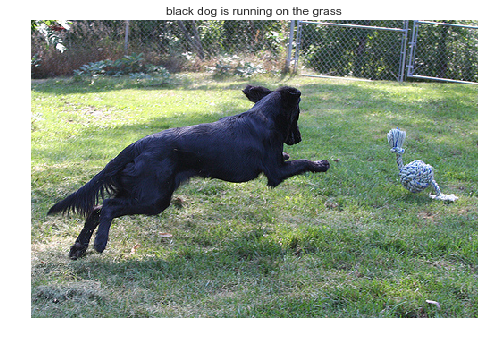

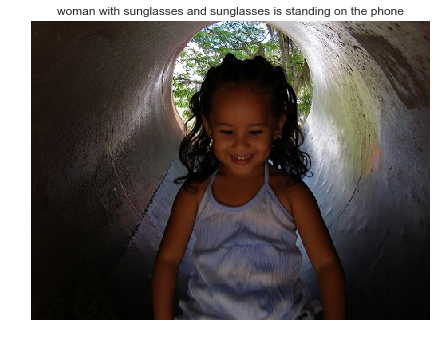

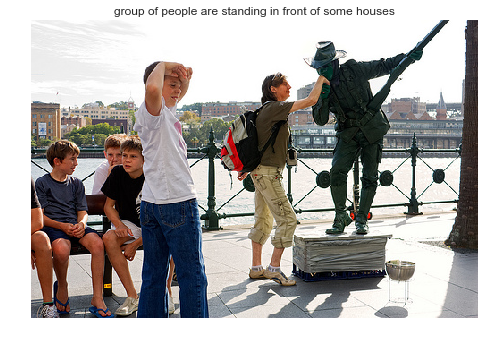

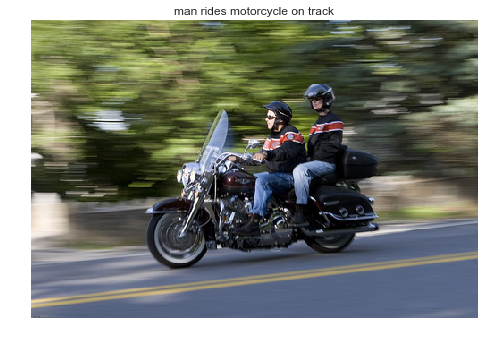

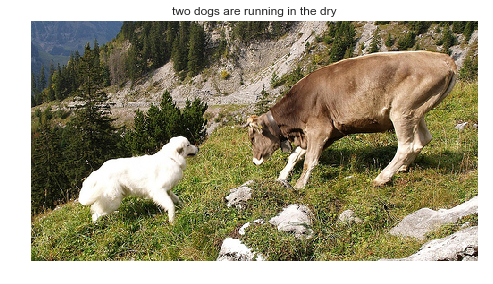

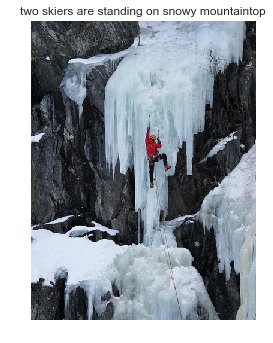

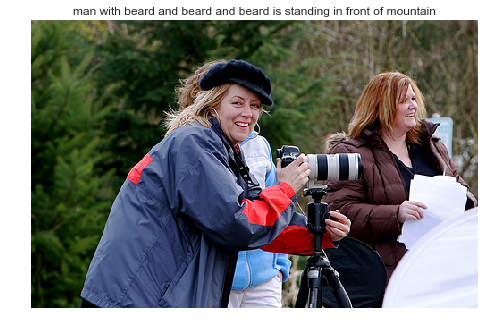

In [140]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread(IMG_PATH+'\\'+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    